# Neural Networks
## Motivation

In the previous chapter, it was mentioned that the target function $f_0$ can be very complicated.

Let uns consider the following (still quite simple) example:

$$Y=2-3X_1+1.5X_2 +3X_1^2 + 2\sin(0.6X_1+0.5X_2)  +\varepsilon,$$

In [1]:
import torch;import matplotlib.pyplot as plt; import numpy as np
def dgp_poly_regression (weights, intercept, n):
    X = torch.normal(0,1,(n,2))
    Y = intercept + torch.mv(X,weights[0:2]) + weights[2]*X[:,0]**2 + weights[3]*torch.sin(0.6*X[:,0]+.5*X[:,1]) + torch.normal(0,1,(1,n))
    return X,Y.reshape((-1,1))

true_weights = torch.tensor([-3.0, -1.5, 3.0, 5.0])
true_intercept = 2

#generate data
n_obs = 500
torch.manual_seed(42) #set a seed for replicability
features, labels = dgp_poly_regression(true_weights,true_intercept, n_obs)

#split the sample
from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(np.arange(len(labels)), test_size=0.20, random_state=42) 

Let us take a look at the generated data.

<center>
<img src="./figures/NN/motivation_1.png" alt="Drawing" style="width: 1000px;"/><br>
<b>Figure 1:</b> Scatter plot.</center>

If we just fit the plain linear regression, we obtain

In [2]:
from torch.utils import data; from torch import nn
def load_array(data_arrays, batch_size, is_train=True): 
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 50
data_iter = load_array((features[train_idx,:], labels[train_idx]), batch_size)

net_simple = nn.Sequential(nn.Linear(2, 1))
loss = nn.MSELoss()
trainer = torch.optim.SGD(net_simple.parameters(), lr=0.03)
# initializing parameters
net_simple[0].weight.data.normal_(0, 0.01)
net_simple[0].bias.data.fill_(0);

In [3]:
#training the model
num_epochs = 500
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net_simple(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    if(epoch % 100 == 99):
        l = loss(net_simple(features[test_idx,:]),  labels[test_idx] )
        print(f'epoch {epoch + 1}, test loss {l:f}')

epoch 100, test loss 34.073925
epoch 200, test loss 34.189671
epoch 300, test loss 34.052719
epoch 400, test loss 34.134712
epoch 500, test loss 34.039520


In [4]:
w = net_simple[0].weight.data
print('Estimated weights w:',  w)
b = net_simple[0].bias.data
print('Estimated intercept/bias:', b)

Estimated weights w: tensor([[-1.3125,  0.2152]])
Estimated intercept/bias: tensor([4.3660])


<center>
<img src="./figures/NN/motivation_2.png" alt="Drawing" style="width: 1000px;"/><br>
<b>Figure 2:</b> Linear model.</center>

But if we instead directly plug in the transformed features

In [5]:
transf_features = torch.cat((features,(features[:,0]**2).reshape(-1,1),
                           torch.sin(0.6*features[:,0]+0.5*features[:,1]).reshape(-1,1)),dim =1)

batch_size = 50
data_iter_transf = load_array((transf_features[train_idx,:], labels[train_idx]), batch_size)

In [6]:
net_transf = nn.Sequential(nn.Linear(4, 1))
loss = nn.MSELoss()
trainer = torch.optim.SGD(net_transf.parameters(), lr=0.05)
net_transf[0].weight.data.normal_(0, 0.01); net_transf[0].bias.data.fill_(0) # initializing parameters
#training the model
num_epochs = 500
for epoch in range(num_epochs):
    for X, y in data_iter_transf:
        l = loss(net_transf(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    if(epoch % 100 == 99):
        l = loss(net_transf(transf_features[test_idx,:]),  labels[test_idx])
        print(f'epoch {epoch + 1}, test loss {l:f}')
l = loss(net_transf(transf_features[test_idx,:]),  labels[test_idx]); print(f'epoch {epoch + 1}, test loss {l:f}')   

epoch 100, test loss 1.487309
epoch 200, test loss 1.076782
epoch 300, test loss 1.034379
epoch 400, test loss 1.047245
epoch 500, test loss 1.055619
epoch 500, test loss 1.055619


In [7]:
w = net_transf[0].weight.data
print('Estimated weights w:',  w)
b = net_transf[0].bias.data
print('Estimated intercept/bias:', b)

Estimated weights w: tensor([[-3.2741, -1.7056,  3.0209,  5.5282]])
Estimated intercept/bias: tensor([1.9649])


Lets take a look at the model

<center>
<img src="./figures/NN/motivation_3.png" alt="Drawing" style="width: 1000px;"/><br>
<b>Figure 3:</b> Linear model with transformed inputs.</center>

The model corresponds to the following graph
<center>
<img src="./figures/NN/biv_reg_transf.png" alt="Drawing" style="width: 500px;"/><br></center>
<center><b>Figure 4:</b> Linear model with transformed inputs (Graph).</center>

where $\sigma_1,\dots,\sigma_4$ are transformations of the inputs which might be nonlinear (e.g. $\sigma_4\equiv \sin$) and $v_1,\dots,v_4$ are weights for the input features (e.g. $v_4 = (0.6,0.5)^T$).

<b> <center>$\Rightarrow$ Constructing the right features is crucial!</center></b> 

Consider images, where we want to classify picture displays a car or a ship. Knowing whether there are wheels in the image will be very helpful for the prediction.

## (Feedforward) Neural Networks

In the previous chapter we have seen that we can fit more complicated functions, if we can transform the in features in a clever way.

But in general we do **not** know the right transformation for our input variables. Additionally the helpful transformations might be very complex (think of images or speech data).


<b> <center>$\Rightarrow$ Find data driven transformations of the input features, which allow for more accurate predicitons.</center></b> 


In general, we want our created features to be some nonlinear function of the input variables. <br> The basic building block of each neural network will have the following form.

<center>
<img src="./figures/NN/basic_block_graph.png" alt="Drawing" style="width: 800px;"/><br>
<b>Figure 5:</b> Basic building block of neural networks.</center>

As you can observe that this is exactly the graph from the linear model, just with an additional nonlinear transformation on the output which is called **activation function**.

The name activation function derives from the earliest neural networks, where scientists tried to model biological neurons, which *fire* (are activated) if stimulated above a certain threshold.

For this reason the nodes in the graph of a neural network are called **neurons**.

For a given activation function $\sigma$ different weights $w$ result in a different function of $X_1$ and $X_2$.

As a result, we can construct several distict transformed features by combining multiple of these basic building blocks to obtain the analog to the transformed input in the polynomial regression setting.

In principle one can use any nonlinear function $\sigma$ which is differentiable (or almost sure differentiable), but there are some common choices. 

### Activation Functions
We now list some popular choices for activation functions.

#### Sigmoid Function
The sigmoid is the first function, which was used

$$\begin{aligned}
\text{sigmoid}:\mathbb{R}&\to (0,1)\\
x&\mapsto\frac{1}{1+\exp(-x)}
\end{aligned}$$


<center>
<img src="./figures/NN/sigmoid.png" alt="Drawing" style="width: 1000px;"/><br>
<b>Figure 6:</b> Sigmoid function.</center>

The derivation of the sigmoid function is given by

$$\frac{d\text{sigmoid}(x)}{d x}=\text{sigmoid}(x)(1-\text{sigmoid}(x)).$$

#### Tanh Function
The **hyperbolic tangent (tanh) function** is defined as

$$\begin{aligned}
\tanh:\mathbb{R}&\to (-1,1)\\
x&\mapsto\frac{1-\exp(-2x)}{1+\exp(-2x)}.
\end{aligned}$$

In general the tanh function is very similar to the sigmoid function ($\tanh(x)=\text{sigmoid}(2x)-1$), but is point symmetric with respect to the origin.<br>Therefore it resembles the identity more closely and typically performs better than the sigmoid unit.

<center>
<img src="./figures/NN/tanh.png" alt="Drawing" style="width: 1000px;"/><br>
<b>Figure 7:</b> Tanh function.</center>

The derivation of the tanh function is given by

$$\frac{d\tanh(x)}{dx}=1-\tanh^2(x).$$

Sigmoid and tanh units saturate for very small and very large values. The derivative vanishes for $|x|\to \infty$, which makes gradient-based learning difficult.

#### ReLU Function

The most common choice as activation function is the the **rectified linear unit (ReLU)** 

$$\begin{aligned}
\text{ReLU}:\mathbb{R}&\to [0,\infty)\\
x&\mapsto\max(0,x),
\end{aligned}$$

due to its simplicity and good performance in many predictive problems. 

<center>
<img src="./figures/NN/ReLU.png" alt="Drawing" style="width: 1000px;"/><br>
<b>Figure 8:</b> ReLU function.</center>

Its derivative (setting the derivative in $0$ to $0$) is given by 

$$\frac{d\text{ReLU}(x)}{d x}=\begin{cases}1\quad ,x>0\\0\quad ,x\le 0\end{cases}$$

which is very easy to compute and enables gradients for large values of $x$.

There exist a lot of variants of the ReLU function, such as the **parametric ReLU (pReLU)**

$$\begin{aligned}
\text{ReLU}:\mathbb{R}&\to [0,\infty)\\
x&\mapsto\max(0,x)+\alpha\min(0,x),
\end{aligned}$$

where the gradient is not vanishing for negative values (**leaky ReLU** for $\alpha = 0.01$).

<center>
<img src="./figures/NN/leaky_ReLU.png" alt="Drawing" style="width: 1000px;"/><br>
<b>Figure 9:</b> Leaky ReLU function.</center>

Sigmoidal or tanh activation functions are more common in settings, which we will encounter in later sections, other than feedforward networks. <br>
For example in recurrent networks, sigmoid units allow the to control the flow of information over time, making them more appealing despite the drawbacks of saturation.

### Building a Simple Neural Network

Next, we revisit the example, by constructing a simple neural network (or multilayer perceptron) to find a data driven way to engineer the features.

The network will take the following form

<center>
<img src="./figures/NN/graph_small_basic_nn.png" alt="Drawing" style="width: 600px;"/><br>
<b>Figure 10:</b> Simple neural network.</center>

where we omit the bias from the graph (and will do so in the following graphs). How many trainable parameters are contained?

We can concisely implement this easy network by using `nn.Sequential`. 

In [8]:
net = nn.Sequential(nn.Linear(2, 10),
                         nn.ReLU(),
                         nn.Linear(10, 1))

The code sequentially stacks a linear layer with two inputs and ten outputs. Afterwards the ReLU activation function is applied to each outcome in the hidden layer and the last step combines all ten transformed inputs linearly to the final outcome.

Next we continue by initializing the weights and defining the loss and the optimizer.

In [9]:
# initialize the weights
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)
torch.manual_seed(42) #set a seed for replicability
net.apply(init_weights)

# define the loss and the optimizer
loss = nn.MSELoss()
trainer = torch.optim.Adam(net.parameters(), lr=0.03)

Finally we train the model.

In [10]:
num_epochs = 500
print(f'epoch {0}, test loss {loss(net(features[test_idx,:]),  labels[test_idx])}')
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    if(epoch % 100 == 99):
        l = loss(net(features[test_idx,:]),  labels[test_idx])
        print(f'epoch {epoch+1}, test loss {l:f}')

epoch 0, test loss 80.10230255126953
epoch 100, test loss 2.517644
epoch 200, test loss 2.307498
epoch 300, test loss 1.969108
epoch 400, test loss 1.962479
epoch 500, test loss 2.046885


Here, we used an arbitrary structure. <br>

The hyperparameters to choose are the number of hidden layers (multilayer neural networks), the number of neurons in each hidden layers and the choice of the corresponding activation functions.

### Universal Approximation Theorem

There exist some classical results (from Cybenko and Hornik) on the approximation abilities of the single (and multilayer) neural networks. 

One can prove that, under some basic regularity conditions on the activation function $\sigma$, feedforward networks can approximate any (well-behaved) function, provided that sufficiently many hidden nodes are available.

## Deep Neural Networks

Deep neural networks describe networks with a large number of hidden layers. 

<center>
<img src="./figures/NN/graph_deep_nn_1.png" alt="Drawing" style="width: 800px;"/><br>
<b>Figure 11:</b> Deep neural network.</center>

How many parameters (including bias) has this model ?

The previous universal approximation theorem seems to indicate, that there is no need for adding more layers, since we are able to approximate any function sufficiently well.


**But:** We still might need a huge (nearly infinitely large) number of nodes in the hidden layer, which might not be feasible. Instead, adding more layers increases the number the has an exponential effect on the richness of the function class.

### Performance and GPUs

As we have seen the training process can become quite computationally demanding. To speed up calculations, a lot of computation is done in parallel. As a result, GPUs have become very popular due to their ability to perform a large number of task simultaneously.

We how show how to use a NVIDIA GPU for calculations (make sure you have [CUDA](https://developer.nvidia.com/cuda-downloads) installed).

Next, we need to confirm that the GPU version of PyTorch is installed. If a CPU version of PyTorch is already installed, we need to uninstall it first. For example, use the `pip uninstall torch` command, then install the corresponding PyTorch version according to your CUDA version. 

If you are using Colab you can select the use of gpu in (Edit → Notebook Settings → select GPU from the Hardware Accelerator drop-down)

We can specify devices, such as CPUs and GPUs, for storage and calculation. By default, tensors are created in the main memory and then use the CPU for calculations.

Lets check the number of available GPUs:

In [11]:
import torch
torch.cuda.device_count()

1

In PyTorch, the CPU and GPU can be indicated by `torch.device('cpu')` and `torch.cuda.device('cuda')`.<br> It should be noted that the cpu device means all physical CPUs and memory. This means that PyTorch’s calculations will try to use all CPU cores.<br> However, a gpu device only represents one card and the corresponding memory. If there are multiple GPUs, we use `torch.cuda.device(f'cuda:{i}')` to represent the  ith  GPU.

In [12]:
torch.device('cpu'), torch.cuda.device('cuda'), torch.cuda.device('cuda:0')

(device(type='cpu'),
 <torch.cuda.device at 0x273535f9208>)

Before executing on our desired device, we first have to make sure our tensors and models are transferred to the device’s memory. We set up the device to be a GPU if possible.

This can be done with the following lines of code:

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


By default, tensors are created on the CPU. We can query the device where the tensor is located

In [14]:
x = torch.rand(2, 3)
print(x.device)

cpu


We can then set the device for the storage of our tensors by using

In [15]:
y = x.to(device)
print(y)

tensor([[0.0236, 0.1131, 0.0900],
        [0.6350, 0.8746, 0.9939]], device='cuda:0')


In [16]:
print(torch.rand(2, 3, device=device))

tensor([[0.6130, 0.0101, 0.3984],
        [0.0403, 0.1563, 0.4825]], device='cuda:0')


### Real world example

For a real world example, we will use a dataset from [Scikit-learn](https://scikit-learn.org/stable/index.html), which is an open source machine learning library for python. 

**Digression:** `Scikit-learn` provides a large range of machine learning algorithms, such as lasso, boosting, random forests and even basic neural networks.<br> Additionally, it offers various tools for data preprocessing, model selection and many other utilities. For many machine learning problems, it provides unified framework to apply a off-the-shelf machine learning algorithms.

We will use a sample of the [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing).

In [17]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import numpy as np
dataset = fetch_california_housing()
features = dataset.data[0:10000,:]
target = dataset.target[0:10000]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)
target = (target-np.mean(target))/np.std(target)

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25,random_state=42)

features_train.shape, features_test.shape

((7500, 8), (2500, 8))

Next, we specify the device and store the tensors.

In [18]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = torch.tensor(features_train, device = device, dtype = torch.float)
Y_train = torch.tensor(target_train, device = device, dtype = torch.float).reshape(-1,1)
X_test = torch.tensor(features_test, device = device, dtype = torch.float)
Y_test = torch.tensor(target_test, device = device, dtype = torch.float).reshape(-1,1)

Define the data loader.

In [19]:
from torch.utils import data
def load_array(data_arrays, batch_size, is_train=True): 
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)
batch_size = 7500
data_iter = load_array((X_train, Y_train), batch_size)

Further, specify the structure of our network and initialize the weights.

In [20]:
from torch import nn

deep_net = nn.Sequential(nn.Linear(X_train.shape[1], 200),
                    nn.ReLU(),
                    nn.Linear(200, 200),
                    nn.ReLU(),
                    nn.Linear(200, 100),
                    nn.ReLU(),
                    nn.Linear(100, 1))
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)
        
torch.manual_seed(42) #set a seed for replicability
deep_net.apply(init_weights)
deep_net.to(device)
net = deep_net.float() #specifing the right data type for the weights/ net
print('training on', device)

training on cuda:0


Define the loss and the optimization algorithm.

In [21]:
loss = nn.MSELoss()
trainer = torch.optim.Adam(deep_net.parameters(), lr=0.03) #modified version of SDG

Training the model.

In [22]:
num_epochs = 200
with torch.no_grad():
    train_losses = loss(deep_net(X_train), Y_train).cpu().detach().numpy()
    test_losses = loss(deep_net(X_test), Y_test).cpu().detach().numpy() # save the loss at each epoch

for epoch in range(num_epochs):
    for X, Y in data_iter:
        training_loss = loss(deep_net(X) ,Y)
        trainer.zero_grad() #reset the gradient to zero
        training_loss.backward()
        trainer.step()
    with torch.no_grad():
        train_losses = np.append(train_losses,loss(deep_net(X_train), Y_train).cpu().numpy())
        test_losses = np.append(test_losses,loss(deep_net(X_test), Y_test).cpu().numpy())

Take a look a the loss.

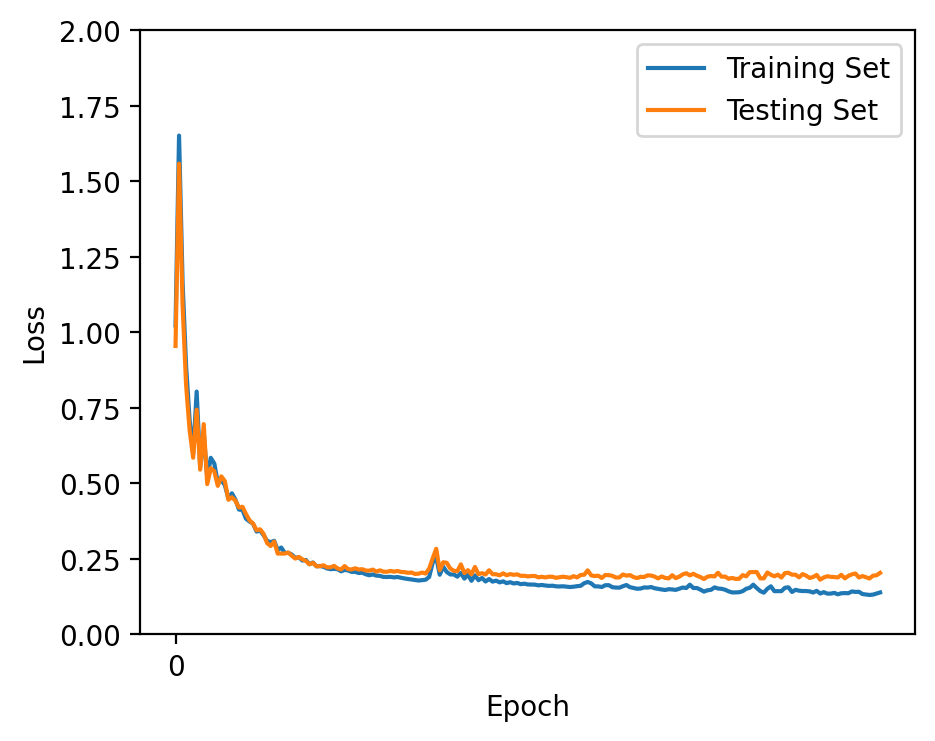

In [23]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,4), dpi= 200)
plt.plot(np.arange(train_losses.shape[0]),train_losses, label='Training Set')
plt.plot(np.arange(test_losses.shape[0]),test_losses, label='Testing Set')
plt.ylabel('Loss');plt.xlabel('Epoch');plt.xticks(np.arange(0, train_losses.shape[0], step=500))
plt.ylim((0, 2))
plt.legend()
plt.show()

### Dropout

There are different ways to try to avoid overfitting for deep neural networks. In this section, we will discuss the idea of increasing the robustness of the model by using pertubations.

Dropout is the idea to randomly remove different nodes from the layer at each training step.

<center>
<img src="./figures/NN/graph_dropout.png"  style="width: 800px;"/><br></center>
<center><b>Figure 13:</b> Neural Network during training with dropout in the second and third hidden layer.</center>

The function `torch.nn.Dropout` randomly zeros some elements of the input tensor with probability `p` (during training).<br> This corresponds to randomly dropping nodes (where each node is dropped according to a Bernoulli distribution with parameter `p`). Furthermore, the outputs are scaled by a factor of $\frac{1}{1-p}$ during training (training is the default when a model is created,to set a model to training use `model.train()`). 

In [24]:
dropout = nn.Dropout(p=0.5)
input = torch.randn(4, 5)
output = dropout(input)
output

tensor([[ 0.7158,  0.0000, -0.1296, -1.1927, -0.0000],
        [ 0.2562,  0.4110,  1.6104, -0.6936,  0.1122],
        [-0.0000, -1.4647, -0.8080,  0.0000, -4.2936],
        [-0.0000,  0.0000, -0.0000,  1.0302, -0.0000]])

During testing or prediction (set the model to `model.eval()`), the module simply computes an identity function.

In [25]:
dropout.eval()
output = dropout(input)
output

tensor([[ 0.3579,  1.3661, -0.0648, -0.5964, -1.1349],
        [ 0.1281,  0.2055,  0.8052, -0.3468,  0.0561],
        [-0.6453, -0.7323, -0.4040,  0.1915, -2.1468],
        [-1.2842,  0.7121, -1.3042,  0.5151, -0.0721]])

### $L_2$ Regularization or Weight Decay

In machine learning, a popular tool to avoid overfitting is to apply shrinkage or regularization.<br>
The motivation originates from the high-dimensional linear regression. In the high-dimensional linear regression setting

$$Y = w^TX+\varepsilon,$$

with $X= (X_1,\dots,X_p)^T$ and the number of features $p$ exceeds the number of observations $n$. 

As a consequence, the solution to 

$$\hat{w}=\arg\min_{w\in\mathbb{R}^p}\mathbb{E}_n[(Y-w^T X)^2]=\arg\min_{w\in\mathbb{R}^p}\frac{1}{n}\sum\limits_{i=1}^n(Y_i-w^T X_i)^2$$

is not unique and able to perfectly fit the observations (overfitting).

High-dimensional statistics is a large field of research and there exist several popular methods which try to avoid overfitting. Two of the most popular methods are **lasso regression**

$$\hat{w}=\arg\min_{w\in\mathbb{R}^p}\left(\mathbb{E}_n[(Y-w^T X)^2] + \lambda \|w\|_1\right)=\arg\min_{w\in\mathbb{R}^p}\left(\frac{1}{n}\sum\limits_{i=1}^n(Y-w^T X)^2 + \lambda \sum\limits_{i=1}^n |w|\right)$$

and **ridge regression**

$$\hat{w}=\arg\min_{w\in\mathbb{R}^p}\left(\mathbb{E}_n[(Y-w^T X)^2] + \lambda \|w\|_2^2\right)=\arg\min_{w\in\mathbb{R}^p}\left(\frac{1}{n}\sum\limits_{i=1}^n(Y-w^T X)^2 + \lambda \sum\limits_{i=1}^n w^2\right).$$

Here, $\lambda$ is a tuning parameter which determines the strengh of the penalization. Both methods (especially lasso) have nice theoretical properties and are discussed in more detail in the machine learning lecture.

**Intuition of the penalization:**<br> The most simple model would be $w^TX\equiv 0$, which corresponds to all weights being zero. Adding an additional term which penalizes using a larger weight vector, shrinks the estimates in the direction of zero. Lasso and Ridge use different norms to determine the distance from zero.

The $L_2$-penalty from Ridge penalizes large weights much harder than small weights, which are very lightly penalized.<br>
In contrast the $L_1$-penalty from Lasso shrinks some weights exactly to zero, resulting in variable selection.

The same ideas can be used in deep learning.<br>
Now instead of minimizing the only the risk the goal is to minimize
$$\min_{\theta\in\Theta}\left(\mathbb{E}[l(Y,f(X,\theta))]+ \frac{\lambda}{2}\|\theta\|_2^2\right).$$

What will happen during the training?

The gradient will take the following form 

$$\nabla_\theta\mathbb{E}[l(Y,f(X,\theta))] + \lambda \theta,$$

where the factor $\frac{\lambda}{2}$ was just chosen for notational convenience. As long as the penalty is additive, this will result in a similar form for the gradient.

Therefore the updating of the weights changes to 

$$\theta^{(\text{new})} = \theta^{(\text{old})} -\nu_1 \left(\nabla_\theta\mathbb{E}[l(Y,f(X,\theta))]+\lambda \theta^{(\text{old})}\right)= \left(1-\nu_1\lambda\right)\theta^{(\text{old})} -\nu_1 \nabla_\theta\mathbb{E}[l(Y,f(X,\theta))],$$

which is nearly identical to the original update step and does not require a lot of computational resources. This can be achieved by adding `weight_decay` (which corresponds to $\lambda$) to `torch.optim.SDG`.

In [27]:
torch.optim.SGD(deep_net.parameters(), lr=0.03,weight_decay=0.01);

###  Revisiting the Example

Now we revisit the example and add dropout and weight decay.

In [28]:
deep_net_drop = nn.Sequential(nn.Linear(X_train.shape[1], 100),
                    nn.ReLU(),
                    nn.Linear(100, 100),
                    nn.Dropout(0.2),
                    nn.ReLU(),
                    nn.Linear(100, 100),
                    nn.ReLU(),
                    nn.Linear(100, 1))

torch.manual_seed(42) #set a seed for replicability
deep_net_drop.apply(init_weights)
deep_net_drop.to(device);

In [29]:
trainer = torch.optim.Adam(deep_net_drop.parameters(), lr=0.03,weight_decay=0.01)
num_epochs = 1000
deep_net_drop.eval()
with torch.no_grad():
    train_losses = loss(deep_net_drop(X_train), Y_train).cpu().detach().numpy()
    test_losses = loss(deep_net_drop(X_test), Y_test).cpu().detach().numpy() # save the loss at each epoch

for epoch in range(num_epochs):
    deep_net_drop.train()
    for X, Y in data_iter:
        training_loss = loss(deep_net_drop(X) ,Y)
        trainer.zero_grad() #reset the gradient to zero
        training_loss.backward()
        trainer.step()
    deep_net_drop.eval()
    with torch.no_grad():
        train_losses = np.append(train_losses,loss(deep_net_drop(X_train), Y_train).cpu().numpy())
        test_losses = np.append(test_losses,loss(deep_net_drop(X_test), Y_test).cpu().numpy())

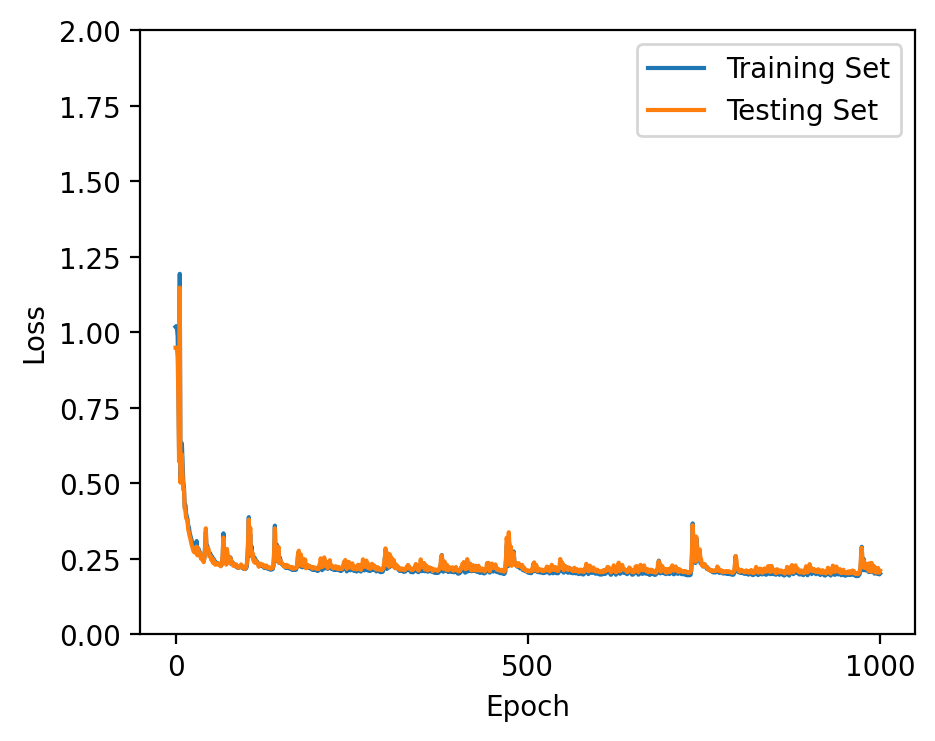

In [30]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,4), dpi= 200)
plt.plot(np.arange(train_losses.shape[0]),train_losses, label='Training Set')
plt.plot(np.arange(test_losses.shape[0]),test_losses, label='Testing Set')
plt.ylabel('Loss');plt.xlabel('Epoch');plt.xticks(np.arange(0, train_losses.shape[0], step=500))
plt.ylim((0, 2))
plt.legend()
plt.show()